In [1]:
import os
import time

import dill
import matplotlib.pyplot as plt
import pyro
import seaborn as sns
import torch
import pyro.distributions as dist
from chirho.dynamical.handlers import LogTrajectory
from chirho.dynamical.handlers.solver import TorchDiffEq
from chirho.dynamical.ops import simulate
from pyro.infer import Predictive
from chirho.observational.handlers import condition
from chirho.dynamical.handlers import LogTrajectory, StaticBatchObservation
from chirho.dynamical.handlers.solver import TorchDiffEq
from chirho.dynamical.ops import Dynamics, State, simulate

pyro.settings.set(module_local_params=True)

sns.set_style("white")

# Set seed for reproducibility
seed = 123
pyro.clear_param_store()
pyro.set_rng_seed(seed)


import matplotlib.pyplot as plt
import seaborn as sns
import torch

from collab.foraging import locust as lc
from collab.foraging import toolkit as ft
from collab.utils import find_repo_root, progress_saver

smoke_test = "CI" in os.environ
subset_starts = 1  # 420
subset_ends = 30 if smoke_test else 900
desired_frames = 50 if smoke_test else 250
#num_iterations = 50 if smoke_test else 100
num_samples = 20 if smoke_test else 150
num_steps = 10 if smoke_test else 500
#sample_size = 100 if smoke_test else 300
#locust_sample_size = 100 if smoke_test else 178770
root = find_repo_root()

notebook_starts = time.time()

In [2]:
locust_count_data_path = os.path.join(
    root, "data/foraging/locust/ds/locust_counts15EQ20191202.pkl"
)

with open(locust_count_data_path, "rb") as f:
    locust_count_data = dill.load(f)

count_data = locust_count_data["count_data"]


def get_count_data_subset(count_data, start, end):
    count_subset = {key: count_data[key][start:end] for key in count_data.keys()}
    init_state = {key[:-4]: count_subset[key][0] for key in count_subset.keys()}

    return {"count_subset": count_subset, "init_state": init_state}

start = 0
end = 40
step_size = 1

logging_times = torch.arange(start, end, step_size)


c_data = get_count_data_subset(count_data, start, end)
subset = c_data["count_subset"]
init_state = c_data["init_state"]

for key in init_state.keys():
    if init_state[key] == torch.tensor(0):
        init_state[key] = torch.tensor(0.001)

print(init_state)
      

{'search_r': tensor(6., dtype=torch.float64), 'feed_l': tensor(1., dtype=torch.float64), 'edge_r': tensor(6., dtype=torch.float64), 'search_l': tensor(2., dtype=torch.float64), 'feed_r': tensor(0.0010), 'edge_l': tensor(0.0010)}


In [3]:
class LocustDynamics(pyro.nn.PyroModule):
    def __init__(self, attraction, wander):
        super().__init__()
        self.attraction = attraction
        self.wander = wander

    def forward(self, X: State[torch.Tensor]):
        dX = dict()
        w_ee, w_es, w_se, w_sf, w_fs, w_ss = torch.unbind(self.wander)
        a_eler, a_erel, a_es, a_se, a_ef, a_sf, a_fs, a_slsr, a_srsl = torch.unbind(
            self.attraction
        )
        epsilon = 0.0001

        dX["edge_l"] = (
            -w_ee * X["edge_l"]  # 1-
            + w_ee * X["edge_r"]  # 2+
            - a_eler * X["edge_r"] * X["edge_l"]  # 3-
            + a_erel * X["edge_l"] * X["edge_r"]  # 4+
            - w_es * X["edge_l"]  # 5-
            - a_es * X["search_l"] * X["edge_l"]  # 6-
            + w_se * X["search_l"]  # 7+
            + a_se * X["edge_l"] * X["search_l"]  # 8+
            - a_ef * X["feed_l"] * X["edge_l"]
        )  + epsilon  # 9-

        dX["edge_r"] = (
            -w_ee * X["edge_r"]  # 2-
            + w_ee * X["edge_l"]  # 1+
            + a_eler * X["edge_r"] * X["edge_l"]  # 3+
            - a_erel * X["edge_l"] * X["edge_r"]  # 4-
            - w_es * X["edge_r"]  # 10-
            - a_es * X["search_r"] * X["edge_r"]  # 11-
            + w_se * X["search_r"]  # 12+
            + a_se * X["edge_r"] * X["search_r"]  # 13+
            - a_ef * X["feed_r"] * X["edge_r"]
        )  + epsilon # 14-

        dX["search_l"] = (
            w_es * X["edge_l"]  # 5+
            - w_se * X["search_l"]  # 7-
            - w_sf * X["search_l"]  # 15-
            - w_ss * X["search_l"]  # 16-
            + w_ss * X["search_r"]  # 17+
            + w_fs * X["feed_l"]  # 23+
            - a_slsr * X["search_l"] * X["search_r"]  # 18-
            + a_srsl * X["search_l"] * X["search_r"]  # 19+
            + a_es * X["search_l"] * X["edge_l"]  # 6+
            - a_se * X["search_l"] * X["edge_l"]  # 8-
            + a_ef * X["feed_l"] * X["edge_l"]  # 9+
            - a_sf * X["feed_l"] * X["search_l"]  # 20-
            + a_fs * X["feed_l"] * X["search_l"]
        )  + epsilon # 24+

        dX["search_r"] = (
            w_es * X["edge_r"]  # 10+
            - w_se * X["search_r"]  # 12-
            - w_sf * X["search_r"]  # 21-
            - w_ss * X["search_r"]  # 17-
            + w_ss * X["search_l"]  # 16+
            + a_slsr * X["search_l"] * X["search_r"]  # 18+
            - a_srsl * X["search_l"] * X["search_r"]  # 19-
            + a_es * X["search_r"] * X["edge_r"]  # 11+
            - a_se * X["search_r"] * X["edge_r"]  # # 13-
            + a_ef * X["feed_r"] * X["edge_r"]  # 14+
            - a_sf * X["feed_r"] * X["search_r"]  # 22-
            + w_fs * X["feed_r"]  # 25+
            + a_fs * X["feed_r"] * X["search_r"]  # 26+
        ) + epsilon

        dX["feed_l"] = (
            w_sf * X["search_l"]  # 15+
            + a_sf * X["feed_l"] * X["search_l"]  # 20+
            - w_fs * X["feed_l"]  # 23-
            - a_fs * X["feed_l"] * X["search_l"]
        )   + epsilon # 24-

        dX["feed_r"] = (
            w_sf * X["search_r"]  # 21+
            + a_sf * X["feed_r"] * X["search_r"]  # 22+
            - w_fs * X["feed_r"]  # 25-
            - a_fs * X["feed_r"] * X["search_r"]  # 26-
        ) + epsilon

        return dX



In [54]:
def logistic(x,total):
    return (1 - x / total) 

class LocustDynamics(pyro.nn.PyroModule):
    def __init__(self, attraction, wander):
        super().__init__()
        self.attraction = attraction
        self.wander = wander

    def forward(self, X: State[torch.Tensor]):
        dX = dict()

        total_count = int(torch.sum(torch.stack([X[key] for key in X.keys()])).item())


        w_sides, w_inside, w_outside, w_feed = torch.unbind(self.wander)        
        a_r, a_l, a_edge, a_search, a_feed = torch.unbind(self.attraction)

        epsilon = 1e-8

        w_edgers_lr = w_sides * X['edge_l']
        w_edgers_rl = w_sides * X['edge_r']

        a_edgers_lr = a_r * X['edge_l'] * X['edge_r']
        a_edgers_rl = a_l * X['edge_r'] * X['edge_l']

        w_edgers_ls = w_inside * X['edge_l']
        w_edgers_rs = w_inside * X['edge_r']

        a_edgers_ls = a_search * X['edge_l'] * X['search_l']
        a_edgers_rs = a_search * X['edge_r'] * X['search_r']

        a_edgers_lf = a_feed * X['edge_l'] * X['feed_l']
        a_edgers_rf = a_feed * X['edge_r'] * X['feed_r']

        w_searchers_le = w_outside * X['search_l']
        w_searchers_re = w_outside * X['search_r']

        a_searchers_le = a_edge * X['search_l'] * X['edge_l']
        a_searchers_re = a_edge * X['search_r'] * X['edge_r']

        w_searchers_lr = w_sides * X['search_l']
        w_searchers_rl = w_sides * X['search_r']

        a_searchers_lr = a_r * X['search_l'] * X['search_r']
        a_searchers_rl = a_l * X['search_r'] * X['search_l']


        w_searchers_lf = w_feed * X['search_l']
        w_searchers_rf = w_feed * X['search_r']

        a_searchers_lf = a_feed * X['search_l'] * X['feed_l']
        a_searchers_rf = a_feed * X['search_r'] * X['feed_r']

        w_feeders_l = w_outside * X['feed_l'] 
        w_feeders_r = w_outside * X['feed_r']

        a_feeders_l = a_search * X['feed_l'] * X['search_l']
        a_feeders_r = a_search * X['feed_r'] * X['search_r']

        dX["edge_l"] = (
            - w_edgers_lr  # 1-
            + w_edgers_rl  # 2+
            - a_edgers_lr  # 3-
            + a_edgers_rl  # 4+
            - w_edgers_ls  # 5-
            - a_edgers_ls  # 7-
            - a_edgers_lf  # 9-
            + w_searchers_le # 11+
            + a_searchers_le #  13+
        ) * logistic(X['edge_l'], total_count) + epsilon

        dX["edge_r"] = (
            - w_edgers_rl  # 2-
            + w_edgers_lr  # 1+
            + a_edgers_lr  # 3+
            - a_edgers_rl  # 4-
            - w_edgers_rs  # 6-
            - a_edgers_rs  # 8-
            - a_edgers_rf  # 10-
            + w_searchers_re # 12+
            + a_searchers_re # 14+
        )  * logistic( X["edge_r"], total_count) + epsilon

        dX['search_l'] = (
            w_edgers_ls  # 5+
            + a_edgers_ls  # 7+
            + a_edgers_lf  #  9+
            - w_searchers_le # 11-
            - w_searchers_lr # 15-
            + w_searchers_rl # 16+
            - w_searchers_lf # 19-
            - a_searchers_lr # 17-
            + a_searchers_rl # 18+
            - a_searchers_le # 13-
            - a_searchers_lf # 21-
            + w_feeders_l # 23+
            + a_feeders_l # 25+
        )  * logistic(X['search_l'], total_count) + epsilon

        dX['search_r'] = (
            w_edgers_rs  # 6+
            + a_edgers_rs  # 8+
            + a_edgers_rf  # 10+
            - w_searchers_re # 12-
            - w_searchers_rl # 16-
            + w_searchers_lr # 15+
            - w_searchers_rf # 20-
            - a_searchers_rl # 18-
            + a_searchers_lr # 17+
            - a_searchers_re # 14-
            - a_searchers_rf # 22-
            + w_feeders_r # 24+
            + a_feeders_r # 26+
        ) * logistic(X['search_r'], total_count) + epsilon


        dX['feed_l'] = (
            w_searchers_lf  # 19+
            + a_searchers_lf  # 21+
            - w_feeders_l # 23-
            - a_feeders_l # 25-
        ) * logistic(X['feed_l'], total_count) + epsilon


        dX['feed_r'] = (
            w_searchers_rf  # 20+ 
            + a_searchers_rf  # 22+
            - w_feeders_r # 24-
            - a_feeders_r # 26-
        ) * logistic(X['feed_r'], total_count) + epsilon

        return dX
        

In [ ]:
class LocustDynamics(pyro.nn.PyroModule):
    def __init__(self, attraction, wander):
        super().__init__()
        self.attraction = attraction
        self.wander = wander

    def forward(self, X: State[torch.Tensor]):
        dX = dict()

        w_sides, w_inside, w_outside, w_feed = torch.unbind(self.wander)        
        a_r, a_l, a_edge, a_search, a_feed = torch.unbind(self.attraction)

        epsilon = 0.0001

        w_edgers_lr = w_sides * X['edge_l']
        w_edgers_rl = w_sides * X['edge_r']

        a_edgers_lr = a_r * X['edge_l'] * X['edge_r']
        a_edgers_rl = a_l * X['edge_r'] * X['edge_l']

        w_edgers_ls = w_inside * X['edge_l']
        w_edgers_rs = w_inside * X['edge_r']

        a_edgers_ls = a_search * X['edge_l'] * X['search_l']
        a_edgers_rs = a_search * X['edge_r'] * X['search_r']

        a_edgers_lf = a_feed * X['edge_l'] * X['feed_l']
        a_edgers_rf = a_feed * X['edge_r'] * X['feed_r']

        w_searchers_le = w_outside * X['search_l']
        w_searchers_re = w_outside * X['search_r']

        a_searchers_le = a_edge * X['search_l'] * X['edge_l']
        a_searchers_re = a_edge * X['search_r'] * X['edge_r']

        w_searchers_lr = w_sides * X['search_l']
        w_searchers_rl = w_sides * X['search_r']

        a_searchers_lr = a_r * X['search_l'] * X['search_r']
        a_searchers_rl = a_l * X['search_r'] * X['search_l']


        w_searchers_lf = w_feed * X['search_l']
        w_searchers_rf = w_feed * X['search_r']

        a_searchers_lf = a_feed * X['search_l'] * X['feed_l']
        a_searchers_rf = a_feed * X['search_r'] * X['feed_r']

        w_feeders_l = w_outside * X['feed_l'] 
        w_feeders_r = w_outside * X['feed_r']

        a_feeders_l = a_search * X['feed_l'] * X['search_l']
        a_feeders_r = a_search * X['feed_r'] * X['search_r']

        dX["edge_l"] = (
            - w_edgers_lr  # 1-
            + w_edgers_rl  # 2+
            - a_edgers_lr  # 3-
            + a_edgers_rl  # 4+
            - w_edgers_ls  # 5-
            - a_edgers_ls  # 7-
            - a_edgers_lf  # 9-
            + w_searchers_le # 11+
            + a_searchers_le #  13+
        ) + epsilon

        dX["edge_r"] = (
            - w_edgers_rl  # 2-
            + w_edgers_lr  # 1+
            + a_edgers_lr  # 3+
            - a_edgers_rl  # 4-
            - w_edgers_rs  # 6-
            - a_edgers_rs  # 8-
            - a_edgers_rf  # 10-
            + w_searchers_re # 12+
            + a_searchers_re # 14+
        ) + epsilon

        dX['search_l'] = (
            w_edgers_ls  # 5+
            + a_edgers_ls  # 7+
            + a_edgers_lf  #  9+
            - w_searchers_le # 11-
            - w_searchers_lr # 15-
            + w_searchers_rl # 16+
            - w_searchers_lf # 19-
            - a_searchers_lr # 17-
            + a_searchers_rl # 18+
            - a_searchers_le # 13-
            - a_searchers_lf # 21-
            + w_feeders_l # 23+
            + a_feeders_l # 25+
        ) + epsilon

        dX['search_r'] = (
            w_edgers_rs  # 6+
            + a_edgers_rs  # 8+
            + a_edgers_rf  # 10+
            - w_searchers_re # 12-
            - w_searchers_rl # 16-
            + w_searchers_lr # 15+
            - w_searchers_rf # 20-
            - a_searchers_rl # 18-
            + a_searchers_lr # 17+
            - a_searchers_re # 14-
            - a_searchers_rf # 22-
            + w_feeders_r # 24+
            + a_feeders_r # 26+
        ) + epsilon

        dX['feed_l'] = (
            w_searchers_lf  # 19+
            + a_searchers_lf  # 21+
            - w_feeders_l # 23-
            - a_feeders_l # 25-
        ) + epsilon


        dX['feed_r'] = (
            w_searchers_rf  # 20+ 
            + a_searchers_rf  # 22+
            - w_feeders_r # 24-
            - a_feeders_r # 26-
        ) + epsilon

        return dX
        


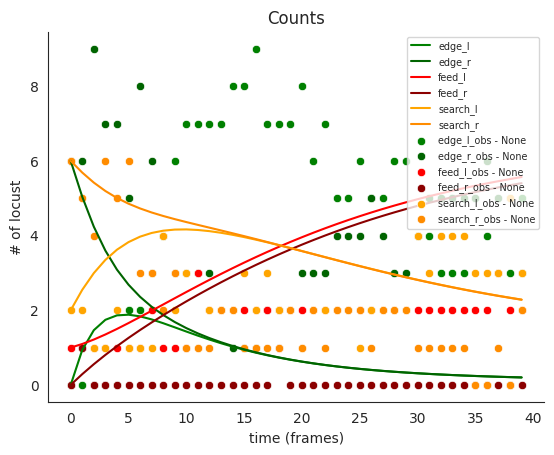

In [53]:
#true_wander = torch.tensor([0.0, 0.0, 0.05, 0.05, 0.0, 0.0])
#true_attraction = torch.tensor([0.01, 0.01, 0.01, 0.01, 0.01, 0.1, 0.01, 0.01, 0.01])

true_wander = torch.tensor([0.2, 0.1, 0.01, 0.05])
true_attraction = torch.tensor([0.01, 0.01, 0.01, 0.01, 0.01])

locust_true = LocustDynamics(true_attraction, true_wander)

start_time = torch.tensor(start).float()
end_time = torch.tensor(end).float()


with TorchDiffEq(method="rk4", ), LogTrajectory(
    logging_times
) as lt:
    simulate(locust_true, init_state, start_time, end_time)

locust_true_traj = lt.trajectory


ft.plot_ds_trajectories(locust_true_traj, logging_times, window_size=0, scatter_data= subset)

In [55]:
def bayesian_locust(base_model=LocustDynamics) -> Dynamics[torch.Tensor]:
    with pyro.plate("attr", size=5):
        attraction = pyro.sample("attraction",  dist.Uniform(0.00001,.1)) # dist.LogNormal(.3, 8))
    with pyro.plate("wond", size=4):
        wander = pyro.sample("wander", dist.Uniform(0.00001, .3)) #dist.LogNormal(.5, 5))

    locust_model = base_model(attraction, wander)
    return locust_model

def locust_noisy_model(X: State[torch.Tensor]) -> None:
    keys = ["edge_l", "edge_r", "search_l", "search_r", "feed_l", "feed_r"]

    counts = torch.stack([X[key] for key in keys], dim=-1)
    total_count = int(torch.sum(counts[0], dim=-1, keepdim=True))

    probs = (counts / total_count).clamp(min=0.0001, max=0.9999)
    probs = probs / probs.sum(-1, keepdim=True)

    with pyro.plate("data", len(X["edge_l"])):
        pyro.sample(
            "counts_obs", dist.Multinomial(total_count, probs=probs)#.to_event(event_dim)
        )

def conditioned_locust_model(
    obs_times, data, init_state, start_time, base_model=LocustDynamics
) -> None:
    bayesian = bayesian_locust(base_model)
    obs = condition(data=data)(locust_noisy_model)
    with TorchDiffEq(method='rk4'), StaticBatchObservation(obs_times, observation=obs):
        simulate(bayesian, init_state, start_time, obs_times[-1])


/home/rafal/miniconda3/envs/collab/lib/python3.10/site-packages/pyro/util.py:303: UserWarning: Found vars in model but not guide: {'counts_obs'}
  warnings.warn(f"Found vars in model but not guide: {bad_sites}")


Running SVI for 500 steps...
[iteration 0001] loss: 332.7179
[iteration 0050] loss: 368.8529
[iteration 0100] loss: 334.2686


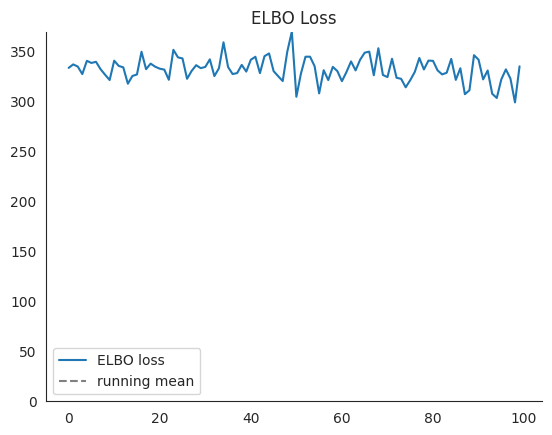

[iteration 0150] loss: 331.0667
[iteration 0200] loss: 332.4339


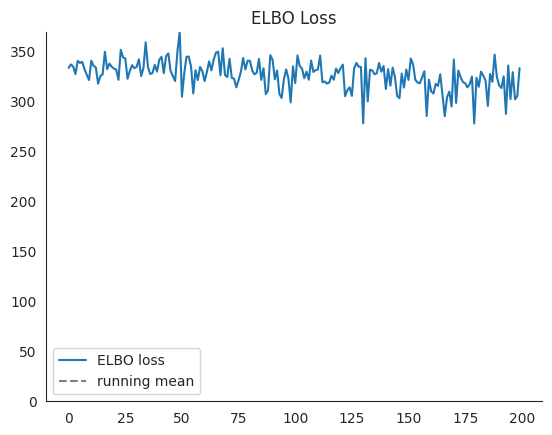

[iteration 0250] loss: 307.2400
[iteration 0300] loss: 296.2076


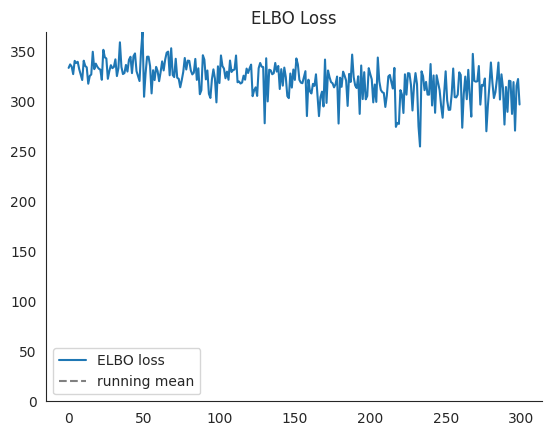

[iteration 0350] loss: 279.1580
[iteration 0400] loss: 314.1638


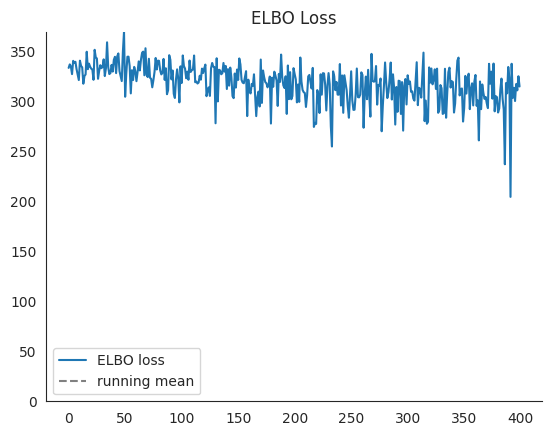

[iteration 0450] loss: 327.7498
[iteration 0500] loss: 327.1983


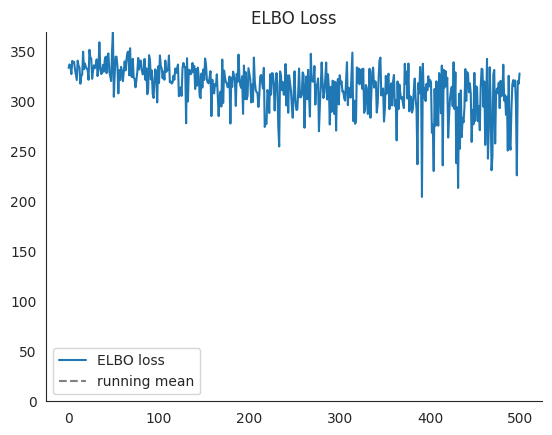

In [69]:
piecemeal_path = os.path.join(root, "data/foraging/locust/ds/time_slices/")
narrow_file_path = os.path.join(piecemeal_path, "narrow_prior.pkl")

if os.path.exists(narrow_file_path):
    with open(narrow_file_path, 'rb') as file:
        samples = dill.load(file)
else:
    print("No samples file found, creating new dict")
    samples = {}


guide = ft.run_svi_inference(
                model=conditioned_locust_model,
                num_steps=num_steps,
                verbose=True,
                lr=0.002,  #0.001 worked well
                blocked_sites=["counts_obs"],
                obs_times=logging_times,
                data=c_data['count_subset'],
                init_state=c_data['init_state'],
                start_time=start_time,
            )




In [70]:
def simulated_bayesian_locust(
    init_state,
    start_time,
    logging_times,
    base_model=LocustDynamics,
) -> State[torch.Tensor]:
    locust_model = bayesian_locust(base_model)
    with TorchDiffEq(), LogTrajectory(logging_times, is_traced=True) as lt:
        simulate(locust_model, init_state, start_time, logging_times[-1])
    return lt.trajectory


def get_locust_prior_samples():
    prior_predictive = Predictive(simulated_bayesian_locust, num_samples=num_samples)
    locust_prior_samples = prior_predictive(init_state, start_time, logging_times)
    return locust_prior_samples

prior_samples = get_locust_prior_samples()


In [71]:

predictive = Predictive(
            simulated_bayesian_locust, guide=guide,
            num_samples=num_samples
        )

samples[f"s{start}_e{end}_steps{num_steps}"] = predictive(c_data['init_state'], 
                                                            start_time, logging_times)

with open(narrow_file_path, 'wb') as file:
    dill.dump(samples, file)



In [92]:
sample = samples[f"s{start}_e{end}_steps{num_steps}"]


mean_preds = {}
abs_errors = {}
maes = {}
for compartment in ["edge_l", "edge_r", "feed_l", "feed_r", "search_l", "search_r"]:
    mean_preds[compartment] = sample[compartment].mean(dim=0)
    abs_errors[compartment] = torch.abs(c_data['count_subset'][f"{compartment}_obs"] - mean_preds[compartment])
    maes[compartment] = abs_errors[compartment].mean()
all_errors = torch.cat([tensor for tensor in abs_errors.values()])
overall_mean = torch.mean(all_errors).item()

print(maes)
print(overall_mean)

# all terms: around 1.09
# just w terms:  around 1.77
# just a terms: around  2.07
# refactored: without logistic terms: 1.29
# refactored: with logistic terms: 2.16, 4 minutes prior sampling, 7 posterior

{'edge_l': tensor(3.2593, dtype=torch.float64), 'edge_r': tensor(1.8290, dtype=torch.float64), 'feed_l': tensor(1.0550, dtype=torch.float64), 'feed_r': tensor(3.7962, dtype=torch.float64), 'search_l': tensor(0.7476, dtype=torch.float64), 'search_r': tensor(1.1578, dtype=torch.float64)}
1.9741547104013706


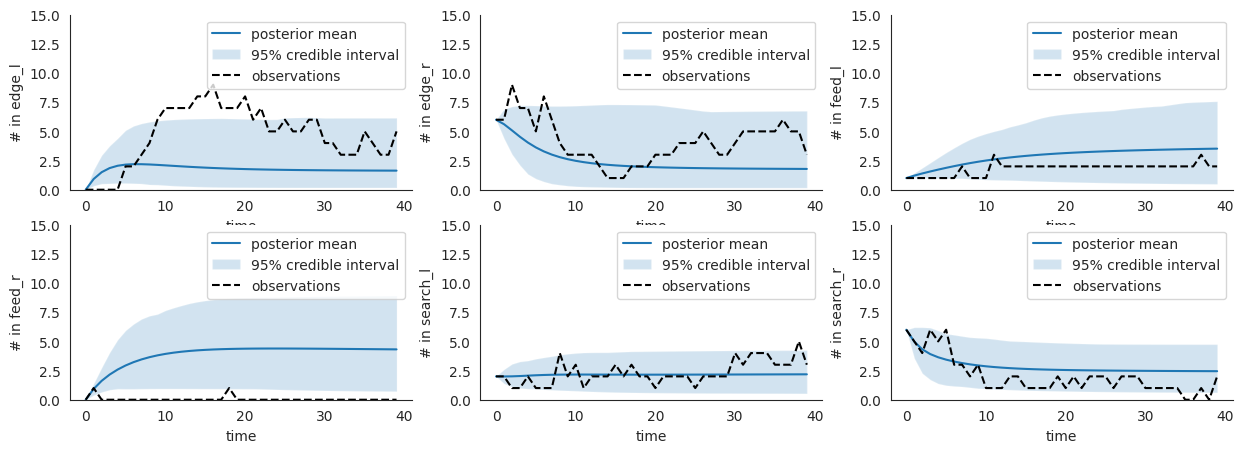

In [93]:
fig, ax = plt.subplots(2, 3, figsize=(15, 5))
ax = ax.flatten()

for i, state, color in zip(
    range(6),
    ["edge_l", "edge_r", "feed_l", "feed_r", "search_l", "search_r"],
    ["green", "darkgreen", "red", "darkred", "orange", "darkorange"],
):
    ft.ds_uncertainty_plot(
        state_pred=sample[state],
        data=c_data['count_subset'][f"{state}_obs"],
        ylabel=f"# in {state}",
        color=color,
        data_label="observations",
        ax=ax[i],
        legend=True,
        test_plot=False,
        mean_label="posterior mean",
        ylim = 15
    )

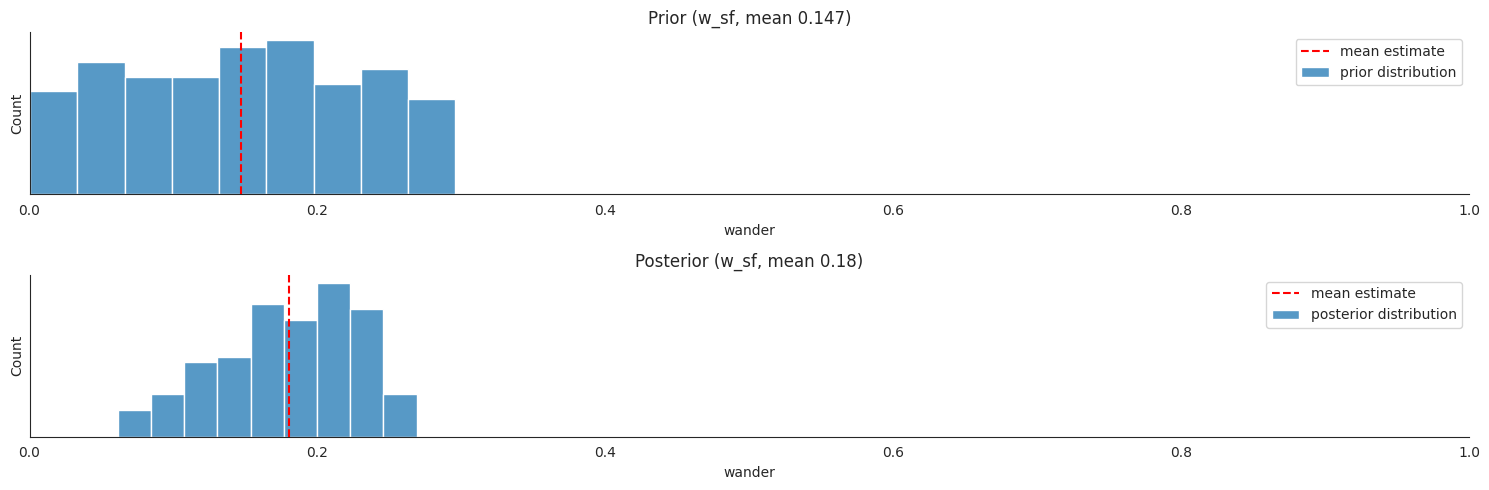

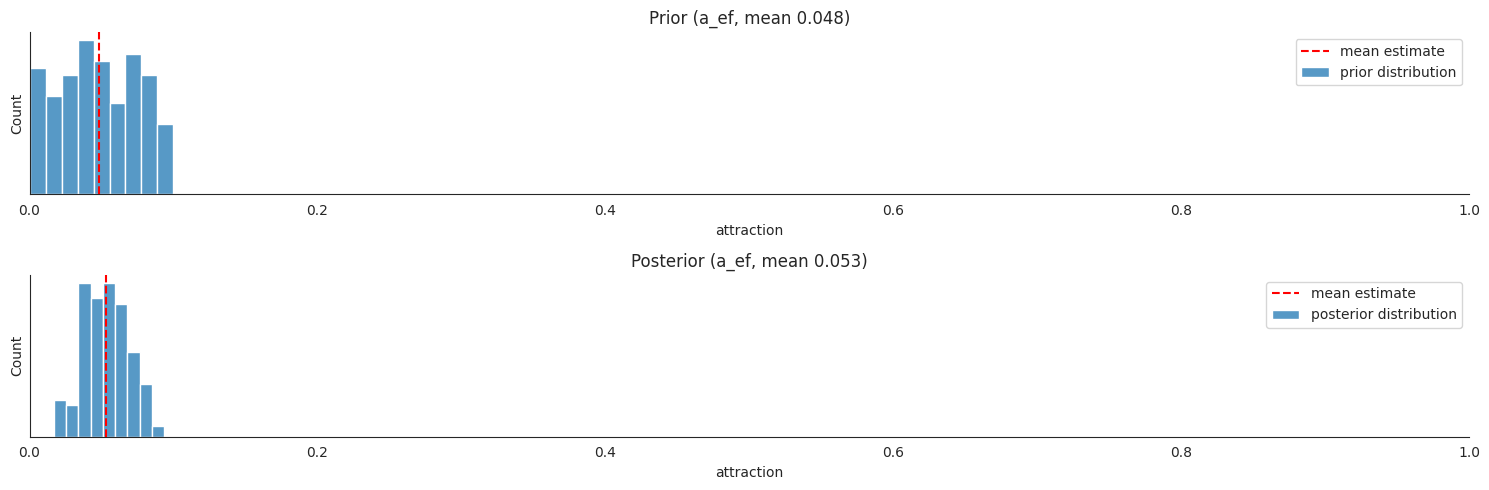

In [94]:
#w_sides, w_inside, w_outside, w_feed 
#a_r, a_l, a_edge, a_search, a_feed 

lc.plot_ds_estimates(
    prior_samples,
    sample,
    "wander",
    3,
    true_attraction=true_attraction,
    true_wander=true_wander,
    xlim=1,
)

lc.plot_ds_estimates(
    prior_samples,
    sample,
    "attraction",
    4,
    true_attraction=true_attraction,
    true_wander=true_wander,
    xlim=1,
)

In [91]:
# baseline null model abs error

c_data['count_subset'].keys()

mean_count_overall = torch.mean(torch.concat(
    [c_data['count_subset'][key] for key in
      c_data['count_subset'].keys()]
))

null_msa = torch.mean(torch.concat([torch.abs(c_data['count_subset'][key] - mean_count_overall) for key in c_data['count_subset'].keys()]))

print(null_msa)


tensor(1.7125, dtype=torch.float64)
